# Chapter 9: Design via Root Locus
---

In [1]:
import sys

if (path := "C:/Users/Tom/pycharm-projects/python-control") not in sys.path:
    sys.path.append(path)

import sympy as sp

from python_control import (
    s, K, 
    TransferFunction, 
    get_damping_ratio,
    is_second_order_approx
)
from python_control.design import (
    plot_step_responses,
    plot_ramp_responses,
    create_second_order_system
)
from python_control.design.root_locus import (
    design_without_compensation,
    design_with_compensation,
    design_lag_compensator,
    design_PD_controller,
    design_lead_compensator,
    design_PID_feedback_system,
    design_lag_lead_feedback_system,
    design_rate_feedback_compensated_system,
    design_minor_loop_feedback_compensated_system
)

## 9.2 : Improving Steady-State Error via Cascade Compensation

### Example 9.1 : Effect of an Ideal Integral Compensator

Given the system, operating with a damping ratio of 0.174, show that the addition of the ideal integral compensator reduces the steady-state error to zero for a step input without appreciably affecting transient response.

![closed-loop system for example 9.1: a. before compensation; b. after ideal integral compensation](./images/example_9-1.png)

**Steady-State Error and Gain of the Uncompensated System**

In [2]:
G_p = TransferFunction(1 / ((s + 1) * (s + 2) * (s + 10)))
zeta = 0.174

In [3]:
sysdata_uc = design_without_compensation(
    G_p,
    damping_ratio=zeta, 
    name='uncompensated system'
)

e_oo, *_ = sysdata_uc.feedback_system.steady_state_error(1 / s)

float(e_oo), sysdata_uc.forward_gain

(0.108382151780018, 164.53222852221776)

**Steady-State Error and Gain of the Compensated System**

The compensating network is chosen with a pole at the origin to increase the system type and a zero at -0.1, close to the compensator pole, so that the angular contribution of the compensator evaluated at the original, dominant, second-order poles is approximately zero. Thus, the original, dominant, second-order closed-loop poles are still approximately on the new root locus.

In [4]:
KG_c = TransferFunction(K * (s + 0.1) / s)  # compensator

In [5]:
sysdata_pi = design_with_compensation(
    KG_c, G_p, 
    damping_ratio=zeta, 
    name='PI-compensated system'
)

e_oo, *_ = sysdata_pi.feedback_system.steady_state_error(1 / s)

float(e_oo), sysdata_pi.forward_gain

(0.0, 158.09700532412074)

**Comparison of the Uncompensated Response with the Ideal Integral Compensated Response and with the Response of the Second-Order System Approximation**

In [6]:
second_order_system = create_second_order_system(
    dominant_pole=sysdata_pi.dominant_pole,
    damping_ratio=zeta,
    name='second-order system'
)

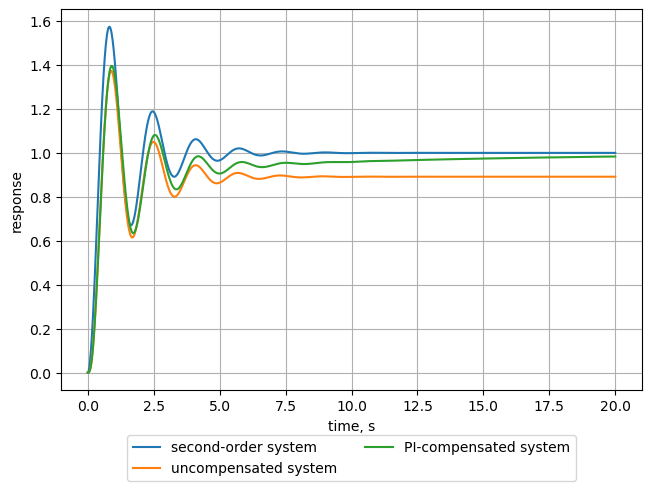

In [7]:
plot_step_responses(sysdata_uc.feedback_system, sysdata_pi.feedback_system, second_order_system, upper_limit=20)

### Example 9.2 : Lag Compensator Design

Compensate the system in example 9.1 to improve the steady-state error by a factor of 10 if the system is operating with a damping ratio of 0.174.

In [8]:
KG_c = design_lag_compensator(
    sysdata_uc.feedback_system,
    e_oo_reduction_factor=10, 
    compensator_pole=-0.01
)

**Steady-State Error and Gain of the Compensated System**

In [9]:
sysdata_lag = design_with_compensation(
    KG_c, G_p,
    damping_ratio=zeta,
    name='lag-compensated system'
)

e_oo, *_ = sysdata_lag.feedback_system.steady_state_error(1 / s)

float(e_oo), sysdata_lag.forward_gain

(0.011279829476930377, 158.02008080567168)

**Comparison of the Uncompensated Response with the Lag Compensated Response**

In [10]:
second_order_system = create_second_order_system(
    dominant_pole=sysdata_lag.dominant_pole,
    damping_ratio=zeta,
    name='second-order system'
)

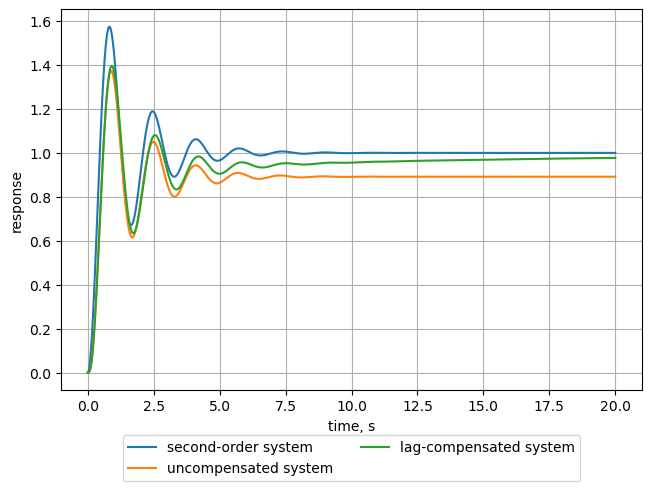

In [11]:
plot_step_responses(sysdata_uc.feedback_system, sysdata_lag.feedback_system, second_order_system, upper_limit=20)

## 9.3 : Improving Transient Response via Cascade Compensation

### Example 9.3 : Ideal Derivative Compensator Design

Given the system below, design an ideal derivative compensator to yield a 16% overshoot, with a threefold reduction in settling time.

![feedback control system for example 9.3](./images/example_9-3.png)

In [12]:
G_p = TransferFunction(1 / (s * (s + 4) * (s + 6)))
percent_overshoot = 16
zeta = get_damping_ratio(percent_overshoot)

**Settling Time and Gain of the Uncompensated System**

In [13]:
sysdata_uc = design_without_compensation(
    G_p,
    damping_ratio=zeta,
    name='uncompensated system'
)
sysdata_uc.settling_time, sysdata_uc.forward_gain

(3.321052329706068, 43.3751465611198)

With a forward gain $K$ of about 43.375, we get a feedback control system with 16% overshoot and a settling time of about 3.321 seconds.

**PD-Controller and PD-Compensated System**<br>
Determine the transfer function of the PD-controller to get a threefold reduction of the settling time.

In [14]:
KG_c = design_PD_controller(
    settling_time=sysdata_uc.settling_time / 3,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p
)
KG_c.expr.collect(K)

K*(1.0*s + 3.00462005703574)

In [15]:
sysdata_pd = design_with_compensation(
    KG_c=KG_c,
    G_plant=G_p,
    damping_ratio=zeta,
    name='PD-compensated system'
)
print(sysdata_pd.settling_time, sysdata_pd.forward_gain)

1.1070174432353554 47.4674987483615


With a forward gain $K$ of about 47.467, we get a feedback control system with 16% overshoot and a settling time of about 1.107 seconds using a PD-controller.

**Comparison of the Uncompensated Response with the Ideal Derivative (PD) Compensated Response and Second-Order System Unit-Step Response**

In [16]:
second_order_system = create_second_order_system(
    dominant_pole=sysdata_pd.dominant_pole,
    damping_ratio=zeta,
    name='second-order system'
)

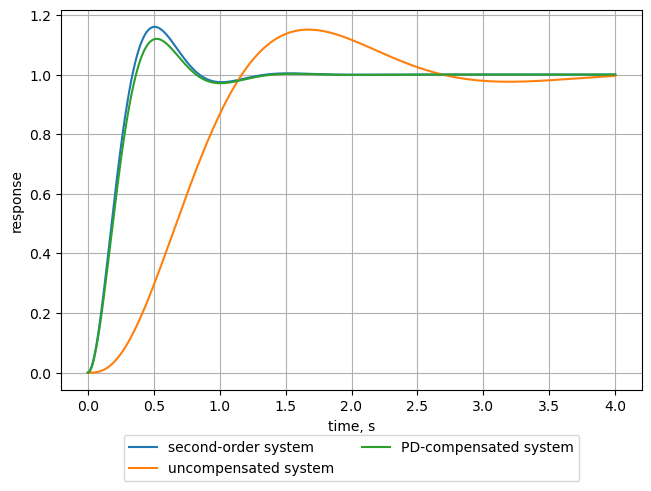

In [17]:
plot_step_responses(
    sysdata_uc.feedback_system,
    sysdata_pd.feedback_system,
    second_order_system,
    upper_limit=4
)

### Example 9.4 : Lead Compensator Design

Design three lead compensators for the system in example 9.3 that will reduce the settling time by a factor of 2 while maintaining 30% overshoot. Compare the system characteristics between the three designs.

In [18]:
G_p = TransferFunction(1 / (s * (s + 4) * (s + 6)))
percent_overshoot = 30
zeta = get_damping_ratio(percent_overshoot)

**Uncompensated System**

In [19]:
sysdata_uc = design_without_compensation(
    G_p, zeta,
    name='uncompensated system'
)

e_oo, *_ = sysdata_uc.feedback_system.steady_state_error(1 / s ** 2)

print(
    f"settling time = {sysdata_uc.settling_time}",
    f"required forward gain = {sysdata_uc.forward_gain}",
    f"natural frequency = {sysdata_uc.natural_frequency}",
    f"peak time = {sysdata_uc.peak_time}",
    f"velocity constant = {sysdata_uc.feedback_system.Kv}",
    f"steady-state error = {float(e_oo)}",
    sep='\n'
)

settling time = 3.9725144551604954
required forward gain = 63.22775812820211
natural frequency = 2.8137456068736255
peak time = 1.1956998422012248
velocity constant = 2.634489922008421
steady-state error = 0.3795801197211046


**Lead Compensator Design 1**

In [20]:
KG_c1 = design_lead_compensator(
    settling_time=sysdata_uc.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=sysdata_uc.plant,
    compensator_zero=-5
)

sysdata_lead1 = design_with_compensation(
    KG_c1, G_p, zeta,
    name='lead-compensated system 1'
)

e_oo, *_ = sysdata_lead1.feedback_system.steady_state_error(1 / s ** 2)

print(
    f"settling time = {sysdata_lead1.settling_time}",
    f"required forward gain = {sysdata_lead1.forward_gain}",
    f"natural frequency = {sysdata_lead1.natural_frequency}",
    f"peak time = {sysdata_lead1.peak_time}",
    f"velocity constant = {sysdata_lead1.feedback_system.Kv}",
    f"steady-state error = {float(e_oo)}",
    sep='\n'
)
print(is_second_order_approx(sysdata_lead1.feedback_system))

settling time = 1.9862572275803383
required forward gain = 1424.5559069678266
natural frequency = 5.627491213746994
peak time = 0.5978499211006397
velocity constant = 6.906515877316715
steady-state error = 0.14479080592348034
True


**Lead Compensator Design 2**

In [21]:
KG_c2 = design_lead_compensator(
    settling_time=sysdata_uc.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=sysdata_uc.plant,
    compensator_zero=-2
)

sysdata_lead2 = design_with_compensation(
    KG_c2, G_p, zeta,
    name='lead-compensated system 2'
)

e_oo, *_ = sysdata_lead2.feedback_system.steady_state_error(1 / s ** 2)

print(
    f"settling time = {sysdata_lead2.settling_time}",
    f"required forward gain = {sysdata_lead2.forward_gain}",
    f"natural frequency = {sysdata_lead2.natural_frequency}",
    f"peak time = {sysdata_lead2.peak_time}",
    f"velocity constant = {sysdata_lead2.feedback_system.Kv}",
    f"steady-state error = {float(e_oo)}",
    sep='\n'
)
print(is_second_order_approx(sysdata_lead2.feedback_system))

settling time = 1.9862572275801513
required forward gain = 345.9046902388284
natural frequency = 5.627491213747524
peak time = 0.5978499211005834
velocity constant = 3.2137289824805704
steady-state error = 0.31116500658625335
False


**Lead Compensator Design 3**

In [22]:
KG_c3 = design_lead_compensator(
    settling_time=sysdata_uc.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=sysdata_uc.plant,
    compensator_zero=-4
)

sysdata_lead3 = design_with_compensation(
    KG_c3, G_p, zeta,
    name='lead-compensated system 3'
)

e_oo, *_ = sysdata_lead3.feedback_system.steady_state_error(1 / s ** 2)

print(
    f"settling time = {sysdata_lead3.settling_time}",
    f"required forward gain = {sysdata_lead3.forward_gain}",
    f"natural frequency = {sysdata_lead3.natural_frequency}",
    f"peak time = {sysdata_lead3.peak_time}",
    f"velocity constant = {sysdata_lead3.feedback_system.Kv}",
    f"steady-state error = {float(e_oo)}",
    sep='\n'
)
print(is_second_order_approx(sysdata_lead3.feedback_system))

settling time = 1.9862572275802037
required forward gain = 698.5002626683312
natural frequency = 5.627491213747375
peak time = 0.5978499211005992
velocity constant = 5.796434796528945
steady-state error = 0.17251983936726517
True


**Comparison between Uncompensated System and Lead Compensator Designs**

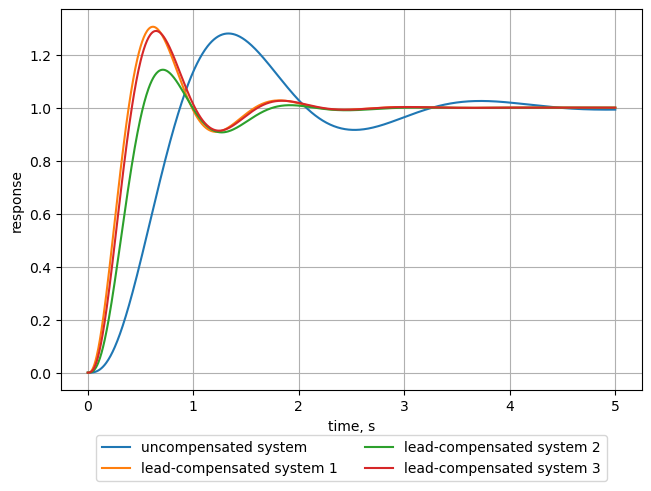

In [23]:
plot_step_responses(
    sysdata_uc.feedback_system,
    sysdata_lead1.feedback_system,
    sysdata_lead2.feedback_system,
    sysdata_lead3.feedback_system,
    upper_limit=5
)

## 9.4 : Improving Steady-State Error and Transient Response

### Example 9.5 : PID Controller Design 

For the system below, design a PID controller so that the system can operate with a peak time that is two-thirds that of the uncompensated system at 20% overshoot and with zero steady-state error for a step input.

![uncompensated feedback control system for example 9.5](./images/example_9-5.png)

**Uncompensated System**

In [24]:
G_p = TransferFunction((s + 8) / ((s + 3) * (s + 6) * (s + 10)))
zeta = get_damping_ratio(percent_overshoot=20)

In [25]:
sysdata_uc = design_without_compensation(G_p, zeta, name='uncompensated system')

print(
    f"required forward gain = {sysdata_uc.forward_gain}",
    f"peak time = {sysdata_uc.peak_time}",
    f"settling time = {sysdata_uc.settling_time}",
    f"steady-state error = {sysdata_uc.steady_state_error('step')}",
    f"second-order approximation valid = {is_second_order_approx(sysdata_uc.feedback_system)}",
    sep='\n'
)

required forward gain = 121.55395211140856
peak time = 0.29718773299609175
settling time = 0.7386124825321843
steady-state error = 0.15619148013793402
second-order approximation valid = True


**PID-compensated System**<br>
First, a compensated system with a PD-controller is designed to meet the transient response specifications. Then, an integral compensator is added to this PD-compensated system to yield the required steady-state error.

We can decide where the zero of the integral compensator should be placed on the real-axis of the complex plane. This should be close to the origin. 

In [26]:
sysdata_pid, sysdata_pd = design_PID_feedback_system(
    settling_time=None,
    peak_time=sysdata_uc.peak_time * 2 / 3,
    damping_ratio=zeta,
    G_plant=sysdata_uc.plant,
    integrator_zero=-0.5,
    names=('PID-compensated system', 'PD-compensated system')
)

print(
    "PD-compensated system",
    "---------------------",
    f"required forward gain = {sysdata_pd.forward_gain}",
    f"peak time = {sysdata_pd.peak_time}",
    f"settling time = {sysdata_pd.settling_time}",
    f"steady-state error = {sysdata_pd.steady_state_error('step')}",
    f"proportional gain = {sysdata_pd.controller_gains.K_p}",
    f"derivative gain = {sysdata_pd.controller_gains.K_d}",
    f"second-order approximation valid = {is_second_order_approx(sysdata_pd.feedback_system)}",
    sep='\n'
)
print()
print(
    "PID-compensated system",
    "----------------------",
    f"required forward gain = {sysdata_pid.forward_gain}",
    f"peak time = {sysdata_pid.peak_time}",
    f"settling time = {sysdata_pid.settling_time}",
    f"steady-state error = {sysdata_pid.steady_state_error('step')}",
    f"proportional gain = {sysdata_pid.controller_gains.K_p}",
    f"integral gain = {sysdata_pid.controller_gains.K_i}",
    f"derivative gain = {sysdata_pid.controller_gains.K_d}",
    f"second-order approximation valid = {is_second_order_approx(sysdata_pid.feedback_system)}",
    sep='\n'
)

PD-compensated system
---------------------
required forward gain = 5.326218688644206
peak time = 0.19812515533072778
settling time = 0.4924083216881226
steady-state error = 0.0701860429450246
proportional gain = 298.076557046019
derivative gain = 5.326218688644206
second-order approximation valid = True

PID-compensated system
----------------------
required forward gain = 4.59150278834797
peak time = 0.21422940959239975
settling time = 0.5324328647593519
steady-state error = 0.0
proportional gain = 300.739666390341
integral gain = 149.03827852301
derivative gain = 5.32621868864421
second-order approximation valid = True


**Comparison between PID-, PD-Compensated Systems and Uncompensated System**

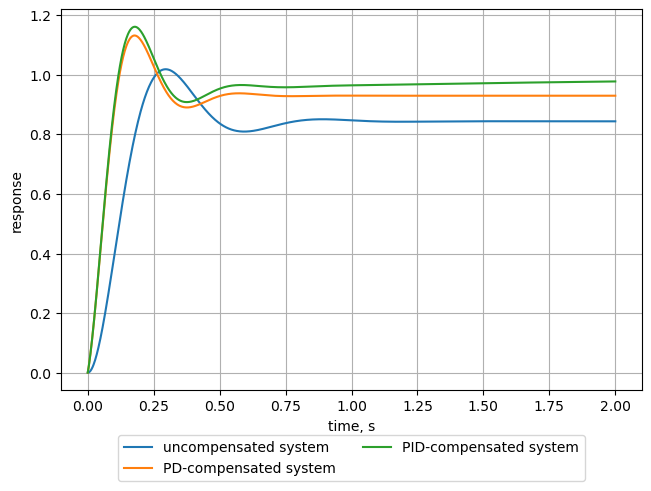

In [27]:
plot_step_responses(
    sysdata_uc.feedback_system,
    sysdata_pd.feedback_system,
    sysdata_pid.feedback_system,
    upper_limit=2.0
)

### Example 9.6 : Lag-Lead Compensator Design

For the system below, design a lag-lead compensator so that the system will operate with 20% overshoot and a twofold reduction in settling time. Further, the compensated system will exhibit a tenfold improvement in steady-state error for a ramp input.

![uncompensated system for example 9.6](./images/example_9-6.png)

**Uncompensated System**

In [28]:
G_p = TransferFunction(1 / (s * (s + 6) * (s + 10)))
zeta = get_damping_ratio(percent_overshoot=20)

In [29]:
sysdata_uc = design_without_compensation(G_p, zeta, name='uncompensated system')

print(
    f"required forward gain = {sysdata_uc.forward_gain}",
    f"peak time = {sysdata_uc.peak_time}",
    f"settling time = {sysdata_uc.settling_time}",
    f"steady-state error = {sysdata_uc.steady_state_error('ramp')}",
    f"second-order approximation valid = {is_second_order_approx(sysdata_uc.feedback_system)}",
    sep='\n'
)

required forward gain = 192.0730938096778
peak time = 0.897347212740733
settling time = 2.2302126868220533
steady-state error = 0.31238107748424665
second-order approximation valid = True


**Lag-Lead Compensated System**<br>
First, a lead-compensated system is designed to meet the transient response specifications. Then, a lag compensator is added to this lead-compensated system to yield the required steady-state error.

In [30]:
sysdata_lag_lead, sysdata_lead = design_lag_lead_feedback_system(
    settling_time=sysdata_uc.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    e_oo_reduction=10.0,
    G_plant=sysdata_uc.plant,
    lead_compensator_zero=-6,
    lag_compensator_pole=-0.01,
    names=('lag-lead system', 'lead system')
)

In [31]:
print(
    "lead-compensated system",
    "-----------------------",
    f"required forward gain = {sysdata_lead.forward_gain}",
    f"peak time = {sysdata_lead.peak_time}",
    f"settling time = {sysdata_lead.settling_time}",
    f"steady-state error = {sysdata_lead.steady_state_error('ramp')}",
    f"second-order approximation valid = {is_second_order_approx(sysdata_lead.feedback_system)}",
    sep='\n'
)
print()
print(
    "lag-lead-compensated system",
    "---------------------------",
    f"required forward gain = {sysdata_lag_lead.forward_gain}",
    f"peak time = {sysdata_lag_lead.peak_time}",
    f"settling time = {sysdata_lag_lead.settling_time}",
    f"steady-state error = {sysdata_lag_lead.steady_state_error('ramp')}",
    f"second-order approximation valid = {is_second_order_approx(sysdata_lag_lead.feedback_system)}",
    sep='\n'
)

lead-compensated system
-----------------------
required forward gain = 1974.653694938492
peak time = 0.44867360637036635
settling time = 1.1151063434110264
steady-state error = 0.14725443225035043
second-order approximation valid = True

lag-lead-compensated system
---------------------------
required forward gain = 1969.3006556197015
peak time = 0.4504572140610515
settling time = 1.119539214482114
steady-state error = 0.031238107748424646
second-order approximation valid = True


**Comparison between Lag-Lead-Compensated System, Lead-Compensated System and Uncompensated System**

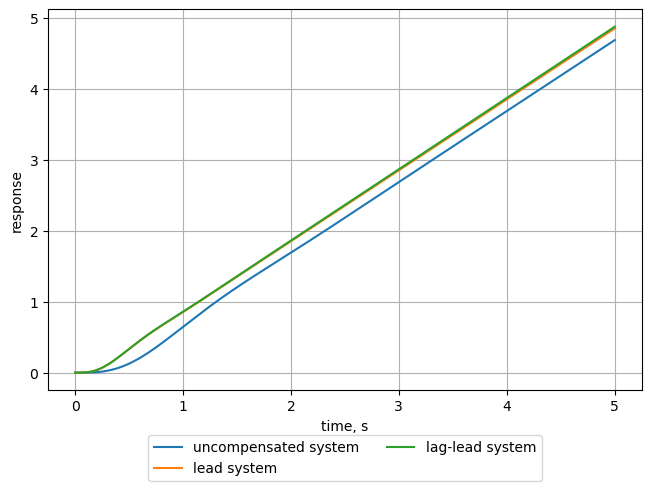

In [32]:
plot_ramp_responses(
    sysdata_uc.feedback_system,
    sysdata_lead.feedback_system,
    sysdata_lag_lead.feedback_system,
    upper_limit=5.0
)

## 9.5 : Feedback Compensation

### Example 9.7 : Compensating Zero via Rate Feedback

For the uncompensated system shown below, design rate feedback compensation to reduce the settling time by a factor of 4 while continuing to operate the system with 20% overshoot.

![system for example 9.7](./images/example_9-7.png)

**Uncompensated System**

In [33]:
zeta = get_damping_ratio(percent_overshoot=20)
G_p = TransferFunction(1 / (s * (s + 5) * (s + 15)))

In [34]:
sysdata_uc = design_without_compensation(
    G_p, zeta,
    name='uncompensated system',
    gain_symbol=sp.Symbol('K_1', real=True, positive=True)
)

print(
    f"closed-loop transfer function = {sysdata_uc.feedback_system.closed_loop.expr}",
    f"forward-path gain = {sysdata_uc.forward_gain}",
    f"settling time = {sysdata_uc.settling_time}",
    sep='\n'
)

closed-loop transfer function = 257.8077082719/(1.0*s**3 + 20.0*s**2 + 75.0*s + 257.8077082719)
forward-path gain = 257.80770827189986
settling time = 2.2114928667385514


**System with Rate Feedback Compensation**

The block diagram of the rate feedback compensated system is shown below:

![system with rate feedback compensation](./images/example_9-7b.png)

The feedback paths of the major loop and the minor loop can be added together in a single feedback-loop:

![equivalent compensated system](./images/example_9-7c.png)

The transfer function of the feedback path now has the form of a PD-controller.

In [35]:
sysdata_cs = design_rate_feedback_compensated_system(
    settling_time=sysdata_uc.settling_time / 4,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=sysdata_uc.plant,
    name='rate feedback compensated system'
)

print(
    f"closed-loop transfer function = {sysdata_cs.feedback_system.closed_loop.expr}",
    f"forward-path transfer function = {sysdata_cs.forward_path.expr}",
    f"open-loop transfer function = {sysdata_cs.feedback_system.open_loop.expr}",
    f"forward-path gain = {sysdata_cs.forward_gain}",
    f"controller gain = {sysdata_cs.feedback_gain}",
    f"open-loop gain = {sysdata_cs.open_loop_gain}",
    f"settling time = {sysdata_cs.settling_time}",
    f"Kv = {sysdata_cs.feedback_system.Kv}",
    f"steady-state error (ramp) = {sysdata_cs.steady_state_error('ramp')}",
    sep='\n'
)

closed-loop transfer function = 1392.42126750243/(1.0*s**3 + 20.0*s**2 + 331.80818763772*s + 1392.42126750243)
forward-path transfer function = 1392.42126750243/(1.0*s**3 + 20.0*s**2 + 75.0*s)
open-loop transfer function = (256.80818763772*s + 1392.42126750243)/(1.0*s**3 + 20.0*s**2 + 75.0*s)
forward-path gain = 1392.4212675024307
controller gain = 0.18443282477173997
open-loop gain = 256.80818763771987
settling time = 0.5528732166846354
Kv = 4.196464461638677
steady-state error (ramp) = 0.23829583430083665


**Comparison between the Unit Step Response of the Uncompensated System and the Compensated System**

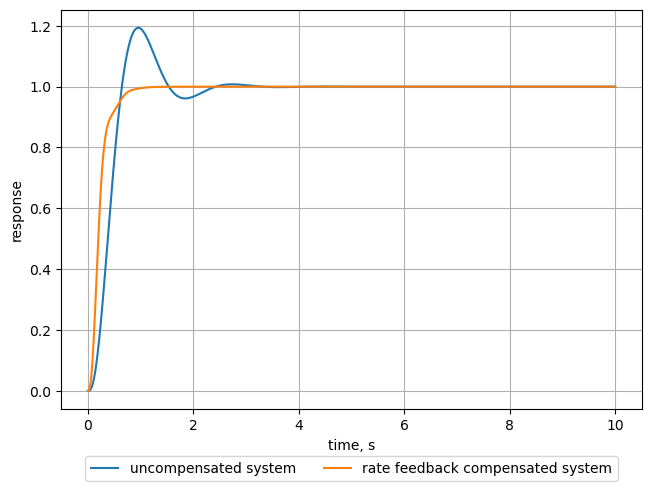

In [36]:
plot_step_responses(
    sysdata_uc.feedback_system,
    sysdata_cs.feedback_system
)

### Example 9.8 : Minor-Loop Feedback Compensation

For the same uncompensated system, design minor-loop feedback compensation to yield a damping ratio of 0.8 for the minor loop and a damping ratio of 0.6 for the closed loop system.

The block diagram of the feedback system with minor-loop feedback compensation is shown below.

![feedback compensated system for example 9.8](./images/example_9-8.png)

**Uncompensated System**

In [37]:
G_p = TransferFunction(1 / (s * (s + 5) * (s + 15)))
sysdata_uc = design_without_compensation(
    G_p, 0.6, 'uncompensated system'
)

print(
    f"closed-loop transfer function = {sysdata_uc.feedback_system.closed_loop.expr}",
    f"forward-path gain = {sysdata_uc.forward_gain}",
    f"settling time = {sysdata_uc.settling_time}",
    sep='\n'
)

closed-loop transfer function = 177.285790246363/(1.0*s**3 + 20.0*s**2 + 75.0*s + 177.285790246363)
forward-path gain = 177.28579024636255
settling time = 2.003169222475805


**Minor-Loop Feedback Compensated System** 

In [38]:
K_f = sp.Symbol('K_f', real=True, positive=True)
H_mnl = TransferFunction(K_f * s)

sysdata_mjl, sysdata_mnl = design_minor_loop_feedback_compensated_system(
    damping_ratio_minor=0.8,
    damping_ratio_major=0.6,
    G_plant=sysdata_uc.plant,
    H_mnl=(H_mnl, K_f),
    name='compensated system'
)

print(
    f"closed-loop transfer function = {sysdata_mjl.feedback_system.closed_loop.expr}",
    f"forward-path transfer function = {sysdata_mjl.forward_path.expr}",
    f"open-loop transfer function = {sysdata_mjl.feedback_system.open_loop.expr}",
    f"forward-path gain = {sysdata_mjl.forward_gain}",
    f"settling time = {sysdata_mjl.settling_time}",
    f"Kv = {sysdata_mjl.feedback_system.Kv}",
    f"steady-state error (ramp) = {sysdata_mjl.steady_state_error('ramp')}",
    sep='\n'
)

closed-loop transfer function = 624.338198644964/(1.0*s**3 + 20.0*s**2 + 156.25*s + 624.338198644964)
forward-path transfer function = 624.338198644964/(1.0*s**3 + 20.0*s**2 + 156.25*s)
open-loop transfer function = 624.338198644964/(1.0*s**3 + 20.0*s**2 + 156.25*s)
forward-path gain = 624.3381986449643
settling time = 0.8821195002218128
Kv = 3.9957644713277696
steady-state error (ramp) = 0.25026500114700345


**Comparison between the Unit Step Response of the Uncompensated System and the Compensated System**

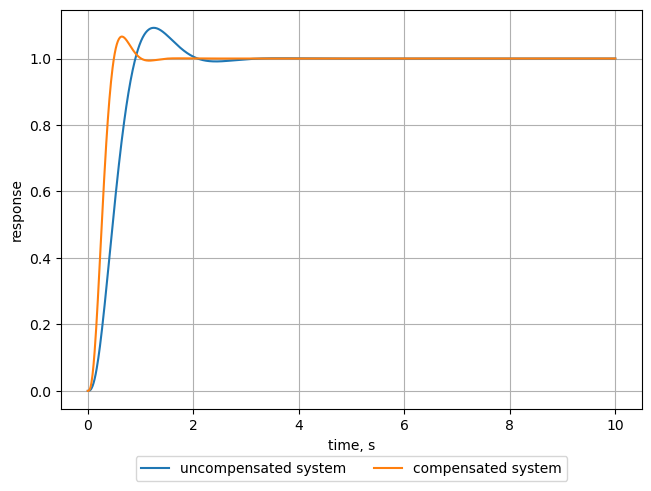

In [39]:
plot_step_responses(
    sysdata_uc.feedback_system,
    sysdata_mjl.feedback_system
)